# Дизайн и проведение А/В-теста по изменению позиции блока с премьерами в стриминговом сервисе

## Введение

**Цель:** оценить, влияет ли изменение позиции блока «Премьеры недели» на пользовательское поведение.

**Гипотеза:** если поднять блок «Премьеры недели» в самый верх главной страницы, то это увеличит его кликабельность и вовлечённость, а также позитивно скажется на метриках потребления контента.

**Условия и ограничения:**

*	Аналогичный эксперимент проводился ранее на других блоках — тогда мы получили реальный прирост ключевой метрики на 2.5%, поэтому ожидаемое минимальное детектируемое изменение (MDE) = 2.5%.
*	Продолжительность теста: 7 дней (важно уложиться до запуска большого промо и смены блока на новые премьеры).
*	Эксперимент охватывает всех пользователей, заходящих на домашнюю страницу в указанный период.
* Тест считается успешным, если тестовая группа показывает значимое улучшение по кликабельности блока и конверсии в начало просмотра.




## 1. Загрузка данных и первичный анализ

In [1]:
# Загружаем все библиотеки необходимые для проекта
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
# Загружаем данные в датафрейм
df = pd.read_csv('/content/drive/MyDrive/zerocod/final_project/data_raw_premieres.csv')

In [3]:
# Выводим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dt          280 non-null    object 
 1   client_id   280 non-null    int64  
 2   ab_group    280 non-null    object 
 3   event_type  280 non-null    object 
 4   content_id  76 non-null     float64
 5   value       15 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 13.3+ KB


In [4]:
# Выводим первые строки для знакомства с данными
df.head()

,dt,client_id,ab_group,event_type,content_id,value
0,2025-04-01 12:41:50,1000,test,view_home,NaN,NaN
1,2025-04-01 15:41:05,1001,test,view_home,NaN,NaN
2,2025-04-03 07:12:50,1002,control,view_home,NaN,NaN
3,2025-04-03 00:22:47,1002,control,view_block,NaN,NaN
4,2025-04-01 23:15:09,1003,control,view_home,NaN,NaN


In [5]:
# Посмотрим уникальные значения и их частоту в столбцах "ab_group" и "event_type"
print(df['ab_group'].value_counts())
print('---' * 20)
print(df['event_type'].value_counts())

ab_group
test       154
control    126
Name: count, dtype: int64
------------------------------------------------------------
event_type
view_home       120
view_block       84
click_block      26
start_watch      20
finish_watch     15
revenue          15
Name: count, dtype: int64


In [6]:
# Посмотрим количество уникальных клиентов
df['client_id'].nunique()

120

In [7]:
# Посмотрим статистику оплаты контента
df['value'].describe()

,value
count,15.000000
mean,1.770000
std,0.776926
min,0.630000
25%,1.060000
50%,1.880000
75%,2.340000
max,2.810000


<Axes: >

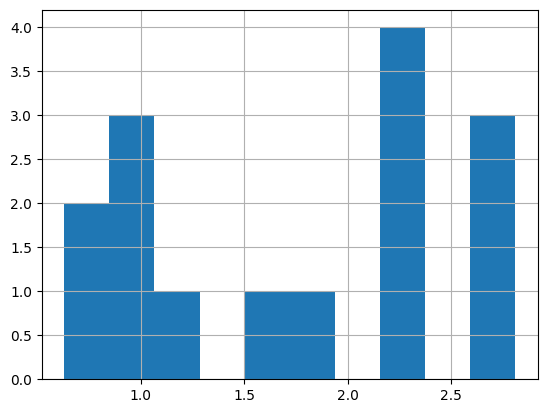

In [8]:
# Построим гистограмму для взносов за контент
df['value'].hist()

In [9]:
# Приводим дату к типу datetime
df['dt'] = pd.to_datetime(df['dt'])

# Проверим диапазон дат
print(df['dt'].min(), '-', df['dt'].max())

2025-04-01 00:03:02 - 2025-04-06 23:22:12


In [10]:
# Проверим длительность теста
print(df['dt'].max() - df['dt'].min())

5 days 23:19:10


In [11]:
# Получаем списки пользователей для каждой группы
test_group = df[df['ab_group']=='test']['client_id']
control_group = df[df['ab_group']=='control']['client_id']

# Преобразуем списки в множества и получаем их пересечение
intersection = list(set(test_group) & set(control_group))

print('Количество пересекающихся пользователей в группах:', len(intersection))

Количество пересекающихся пользователей в группах: 0


### 1.1 Промежуточные выводы

* У нас есть две группы: тестовая и контрольная. В тестовой группе наблюдается больше событий.
* Есть 6 видов событий:
  - *view_home* - посещение домашней страницы,
  - *view_block* - просмотр блока,
  - *click_block* - нажатие на карточку из блока,
  - *start_watch* - начало просмотра,
  - *finish_watch* - досмотрел до конца,
  - *revenue* - оплата за просмотр, если есть.
* Явных выбросов в распределении оплаты за контент не обнаружено. Минимальная оплата - 0.63 у.е., максимальная - 2.81 у.е. Чаще покупали контент за 2.34 у.е.
* Продолжительность эксперимента: 5 дней 23:19:10, с "2025-04-01 00:03:02" по "2025-04-06 23:22:12".
* Количество уникальных клиентов в эксперименте: 120 человек.
* Пересечений в группах между пользователями не обнаружено.

## 2. Дизайн эксперимента

### 2.1 Определение ключевых и дополнительных метрик

В условии ТЗ сказано, что тест считается успешным, если тестовая группа показывает значимое улучшение по кликабельности блока и конверсии в начало просмотра. Значит именно эти метрики и сделаем основными. Также введем несколько дополнительных метрик.

Ключевые метрики:
1) CTR_block - кликабельность блока «Премьеры недели» (кол-во кликов на карточки в блоке / кол-во просмотров блока),
2) CR_start_watch - конверсия в начало просмотра (от просмотра главной страницы --> до старта любого контента из «Премьер недели»).

Дополнительные метрики:
1) CR_finish_watch - конверсия в полное просмотренное видео (начал просмотр контента --> досмотрел до конца),
2) AVG_watch_time - среднее время просмотра по пользователю,
3) ARPU - выручка на пользователя за контент из блока «Премьеры недели» (сумма взносов / кол-во уникальных пользователей).

### 2.2 Общее поведение пользователей по метрикам

**Кликабельность**

In [12]:
# Рассчитываем кликабельность блока
# Найдем количество просмотренных блоков
total_view_block = df.groupby('event_type')['client_id'].nunique().get('view_block')

# Найдем количество блоков на которые кликнули
total_click_block = df.groupby('event_type')['client_id'].nunique().get('click_block')

# Вычисляем кликабельность
CTR_block = (total_click_block / total_view_block)

print(f"Общая кликабельность блока: {CTR_block * 100:.2f}%")
print(f"Всего просмотров блоков: {total_view_block}")
print(f"Всего кликов по блокам: {total_click_block}")

Общая кликабельность блока: 30.95%
Всего просмотров блоков: 84
Всего кликов по блокам: 26


In [13]:
df.groupby(['event_type'])['client_id'].nunique().get('view_block')

np.int64(84)

**Конверсия в начало просмотра**

In [14]:
# Рассчитываем конверсию в начало просмотра
# Найдем количество посещений домашней страницы
total_view_home = df.groupby('event_type')['client_id'].nunique().get('view_home')

# Найдем количество начатых просмотров контента
total_start_watch = df.groupby('event_type')['client_id'].nunique().get('start_watch')

# Вычисляем конверсию
CR_start_watch = (total_start_watch / total_view_home)

print(f"Общая конверсия в начало просмотра: {CR_start_watch * 100:.2f}%")
print(f"Всего заходов на домашнюю страницу: {total_view_home}")
print(f"Всего начатых просмотров: {total_start_watch}")

Общая конверсия в начало просмотра: 16.67%
Всего заходов на домашнюю страницу: 120
Всего начатых просмотров: 20


**Доля досмотревших контент до конца**

In [15]:
# Рассчитываем конверсию в полное просмотренное видео
# Найдем количество законченных просмотров
total_finish_watch  = df.groupby('event_type')['client_id'].nunique().get('finish_watch')

# Вычисляем конверсию
CR_finish_watch = (total_finish_watch / total_start_watch)

print(f"Общая конверсия в полное просмотренное видео: {CR_finish_watch * 100:.2f}%")
print(f"Всего начатых просмотров: {total_start_watch}")
print(f"Всего законченных просмотров: {total_finish_watch}")

Общая конверсия в полное просмотренное видео: 75.00%
Всего начатых просмотров: 20
Всего законченных просмотров: 15


**Среднее время просмотра**

In [16]:
# Рассчитываем среднее время просмотра
# Создадим сводную таблицу с просмотрами для каждого клиента и его контента
watch_times = (
    df[df['event_type'].isin(['start_watch', 'finish_watch'])]
    .pivot_table(index=['client_id', 'content_id'],
                columns='event_type',
                values='dt',
                aggfunc='first')
    .dropna() # удаляем если нет пары start/finish
)

# Расчет времени в часах для каждого клиента и его просмотренного контента
watch_times['duration'] = (watch_times['finish_watch'] - watch_times['start_watch']).dt.total_seconds() / 3600

watch_times

,event_type,finish_watch,start_watch,duration
client_id,content_id,,,
1021,275.0,2025-04-01 19:37:16,2025-04-03 19:10:51,-47.559722
1030,451.0,2025-04-02 20:35:17,2025-04-04 03:32:26,-30.952500
1033,70.0,2025-04-05 11:32:37,2025-04-03 02:54:19,56.638333
1042,427.0,2025-04-06 13:11:00,2025-04-03 22:47:46,62.387222
1050,136.0,2025-04-03 07:25:36,2025-04-02 22:55:43,8.498056
1054,489.0,2025-04-04 00:18:07,2025-04-01 02:53:59,69.402222
1059,374.0,2025-04-02 12:53:54,2025-04-06 09:17:03,-92.385833
1061,378.0,2025-04-06 06:04:22,2025-04-02 04:15:41,97.811389
1071,14.0,2025-04-03 12:20:06,2025-04-01 22:15:50,38.071111


Для некоторых пользователей продолжительность просмотра получается отрицательной, возможно из-за ошибки логирования. Корректно рассчитать среднее время просмотра не получиться.

**Выручка на пользователя**

In [17]:
# Рассчитаем ARPU
# Найдем общую выручку от контента (сумма revenue)
total_revenue = df[df['event_type'] == 'revenue']['value'].sum()

# Найдем количество уникальных пользователей
unique_users = df['client_id'].nunique()

# Вычислим ARPU
arpu = total_revenue / unique_users

print(f"ARPU: {arpu:.2f} у.е.")
print(f"Общая выручка: {total_revenue:.2f} у.е.")
print(f"Количество уникальных пользователей: {unique_users}")

ARPU: 0.22 у.е.
Общая выручка: 26.55 у.е.
Количество уникальных пользователей: 120


**Построим пользовательскую воронку**

In [18]:
# Подсчет количества уникальных user_id на каждом этапе
stage_counts = df.groupby('event_type')['client_id'].nunique().sort_values(ascending=False)

# Вычисление процента от предыдущего этапа
prev_counts = stage_counts.shift(+1)  # Сдвигаем значения на 1 этап вперед
stage_percent = (stage_counts / prev_counts * 100).fillna(100).round(1)

# Форматирование подписей: количество + процент от предыдущего
text_labels = [
    f"({pct}% от предыдущего)"
    for pct in stage_percent.values
]
# Построение воронки
fig = go.Figure(go.Funnel(
    y = stage_counts.index,
    x = stage_counts.values,
    text=text_labels,
    marker = {"color":["#00cc96", "#ffa15a", "#ff6692", "#636efa", "#ab63fa", "#19d3f3", "#e763fa"]}
))
fig.update_layout(title="Воронка пользователей с конверсией между этапами", title_x=0.5, width=800, height=600)
fig.show()

Узкое место образовалось между просмотром блока и нажатием на него. Можно сравнить с результатами из предыдущих экспериментов.

### 2.3 Определение размера выборки и MDE

Параметры для нашего теста:
1) уровень значимости: 0.05
2) мощность: 0.8
3) MDE: 0.025 (2.5%)

**Размер выборки для кликабельности**

In [19]:
def sample_size_ctr(CTR, mde=0.025, alpha=0.05, power=0.8):
    """
    Расчет размера выборки для теста CTR с абсолютным MDE

    Параметры:
    CTR: базовый CTR в долях
    mde: минимальный детектируемый эффект в долях
    alpha: уровень значимости (вероятность ошибки 1-го рода)
    power: мощность теста (1 - вероятность ошибки 2-го рода)
    """
    # Критические значения
    z_alpha = stats.norm.ppf(1 - alpha)
    z_beta = stats.norm.ppf(power)

    # CTR с ожидаемым эффектом и без
    ctr_control = CTR
    ctr_treatment = CTR + mde

    # Средний CTR
    pooled_ctr = (ctr_control + ctr_treatment) / 2

    # Формула для размера выборки
    n = ((z_alpha * np.sqrt(2 * pooled_ctr * (1 - pooled_ctr)) +
          z_beta * np.sqrt(ctr_control * (1 - ctr_control) +
                          ctr_treatment * (1 - ctr_treatment))) ** 2) / (mde ** 2)

    return np.ceil(n).astype(int)

sample_size = sample_size_ctr(CTR_block)
print(f"Размер выборки на одну группу: {sample_size}")
print(f"Общий размер выборки: {2 * sample_size}")

Размер выборки на одну группу: 4319
Общий размер выборки: 8638


**Размер выборки для конверсии в просмотр**

In [20]:
def sample_size_proportion(conversion_rate, mde=0.025, alpha=0.05, power=0.8):
    """
    Расчет размера выборки для теста конверсии в просмотр с абсолютным MDE

    Параметры:
    conversion_rate: базовая конверсия в долях
    mde: минимальный детектируемый эффект в долях
    alpha: уровень значимости (вероятность ошибки 1-го рода)
    power: мощность теста (1 - вероятность ошибки 2-го рода)
    """
    # Критические значения
    z_alpha = stats.norm.ppf(1 - alpha)
    z_beta = stats.norm.ppf(power)

    # Конверсия с ожидаемым эффектом и без
    p1 = conversion_rate
    p2 = conversion_rate + mde

    # Средняя конверсия
    pooled_p = (p1 + p2) / 2

    # Формула для размера выборки на одну группу
    n = ((z_alpha * np.sqrt(2 * pooled_p * (1 - pooled_p)) +
          z_beta * np.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2) / (mde ** 2)

    return np.ceil(n).astype(int)

sample_size = sample_size_proportion(CR_start_watch)
print(f"Размер выборки на одну группу: {sample_size}")
print(f"Общий размер выборки: {2 * sample_size}")

Размер выборки на одну группу: 2909
Общий размер выборки: 5818


В нашем эксперименте значительно меньше пользователей, чем рассчитанные необходимые выборки. Посмотрим какой эффект мы сможем получить для нашего фактического размера выборки.

**Расчет MDE для кликабельности**

In [21]:
def get_mde_ctr_simple(ctr, total_impressions, r=1, alpha=0.05, beta=0.2):
    """
    Упрощенный расчет MDE для CTR (считаем клики как биномиальное распределение)

    Parameters:
    ctr: текущий CTR
    total_impressions: количество показов блока
    r: соотношение контроль/тест
    alpha, beta: параметры теста

    Returns:
    mde_abs: абсолютный MDE
    """

    # Критические значения
    t_alpha = stats.norm.ppf(1 - alpha)
    t_beta = stats.norm.ppf(1 - beta)

    # Стандартное отклонение пропорции
    std = np.sqrt(ctr * (1 - ctr))

    # Количество показов на группу
    n_control = total_impressions / (1 + r)
    n_test = r * n_control

    # Расчет MDE
    variance_term = std * np.sqrt(1/n_control + 1/n_test)
    mde_abs = (t_alpha + t_beta) * variance_term

    return mde_abs

mde_ctr = get_mde_ctr_simple(
    ctr = CTR_block,
    total_impressions = total_view_block
)

print(f"Можем обнаружить изменение CTR_block от {mde_ctr*100:.2f} п.п.")

Можем обнаружить изменение CTR_block от 25.08 п.п.


**Расчет MDE для конверсии в просмотр**

In [22]:
def get_mde_conversion(p, sample_size, r=1, alpha=0.05, beta=0.2):
    """
    Расчет MDE для конверсии в просмотр

    Parameters:
    p: базовая конверсия
    sample_size: общий размер выборки
    r: соотношение контроль/тест
    alpha, beta: параметры теста

    Returns:
    mde_abs: абсолютный MDE
    """

    # Стандартное отклонение пропорции
    std = np.sqrt(p * (1 - p))

    # Критические значения
    t_alpha = stats.norm.ppf(1 - alpha)
    t_beta = stats.norm.ppf(1 - beta)

    # Поправка на соотношение групп
    sample_ratio_correction = (r + 1)**2 / r

    # Расчет MDE
    n_per_group = sample_size / (1 + r)
    mde_abs = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(n_per_group)

    return mde_abs

mde_cr = get_mde_conversion(
    p = CR_start_watch,
    sample_size = unique_users
)

print(f"Можем обнаружить изменение CR_start_watch от {mde_cr*100:.2f} п.п.")

Можем обнаружить изменение CR_start_watch от 23.93 п.п.


### 2.4 Промежуточные выводы

* Определили ключевые метрики:
  + кликабельность,
  + конверсия в просмотр.
* Определили дополнительные метрики:
  + конверсия в полный просмотр,
  + средняя продолжительность просмотра,
  + выручка на пользователя.
* Задали параметры для теста:
  + уровень значимости: 0.05,
  + мощность: 0.8,
  + MDE: 0.025 (2.5%).
* Изучили общее поведение пользователей по заданным метрикам:
  + общая кликабельность блока: 30.95%,
  + общая конверсия в начало просмотра: 16.67%,
  + общая конверсия в полное просмотренное видео: 75.00%,
  + среднюю продолжительность просмотра определить не получилось из-за ошибки логирования,
  + ARPU: 0.22 у.е.
* Узкое место образовалось между просмотром блока и нажатием на него. Просматривать видео начинает каждый 6 пользователь. Из тех кто начал смотреть контент 75% просматривают его до конца.
* Расчетный размер выборки значительно превышает нашу экспериментальную выборку. На нашей выборке мы сможем обнаружить MDE, который будет превышать 24-25%. Для обнаружения эффекта в 2.5% потребуется выборка из 8638 пользователей.
* Можно применить для статистического теста метод бутстрэп, но стоит быть осторожным с результатами. Мы хотим обнаружить маленький эффект на маленькой выборке, что крайне сложно и результат может быть недостоверным.

## 3. Анализ результатов

### 3.1 Разделение трафика на тестовую и контрольную группы

In [23]:
# Рассчитываем агрегированные метрики по группам
result_df = df.groupby('ab_group').apply(lambda x: pd.Series({
    'ctr_block': (x['event_type'] == 'click_block').sum() / (x['event_type'] == 'view_block').sum()
                             if (x['event_type'] == 'view_block').sum() > 0 else np.nan,
    'cr_start_watch': (x['event_type'] == 'start_watch').sum() / (x['event_type'] == 'view_home').sum()
                            if (x['event_type'] == 'view_home').sum() > 0 else np.nan,
    'cr_finish_watch': (x['event_type'] == 'finish_watch').sum() / (x['event_type'] == 'start_watch').sum()
                               if (x['event_type'] == 'start_watch').sum() > 0 else np.nan,
    'arpu': x.loc[x['event_type'] == 'revenue', 'value'].sum() / x['client_id'].nunique()
                         if x['client_id'].nunique() > 0 else np.nan,
    # Дополнительные метрики для проверки
    'view_home_count': (x['event_type'] == 'view_home').sum(),
    'view_block_count': (x['event_type'] == 'view_block').sum(),
    'click_block_count': (x['event_type'] == 'click_block').sum(),
    'start_watch_count': (x['event_type'] == 'start_watch').sum(),
    'finish_watch_count': (x['event_type'] == 'finish_watch').sum(),
    'revenue_count': (x['event_type'] == 'revenue').sum(),
    'unique_clients': x['client_id'].nunique(),
    'revenue_sum': x.loc[x['event_type'] == 'revenue', 'value'].sum()
}), include_groups=False).reset_index()

# Форматирование результатов
result_df = result_df.round({
    'ctr_block': 2,
    'cr_start_watch': 2,
    'cr_finish_watch': 2,
    'arpu': 2
})

result_df

,ab_group,ctr_block,cr_start_watch,cr_finish_watch,arpu,view_home_count,view_block_count,click_block_count,start_watch_count,finish_watch_count,revenue_count,unique_clients,revenue_sum
0,control,0.30,0.19,0.7,0.23,54.0,37.0,11.0,10.0,7.0,7.0,54.0,12.48
1,test,0.32,0.15,0.8,0.21,66.0,47.0,15.0,10.0,8.0,8.0,66.0,14.07


В тестовой группе больше уникальных клиентов и и сумма оплаченных взносов за просмотренный контент тоже тоже превышает сумму из контрольной группы. Рассмотрим остальные показатели с помощью графиков.

### 3.2 Визуальное сравнение групп

**Сравниваем основные и дополнительные метрики**

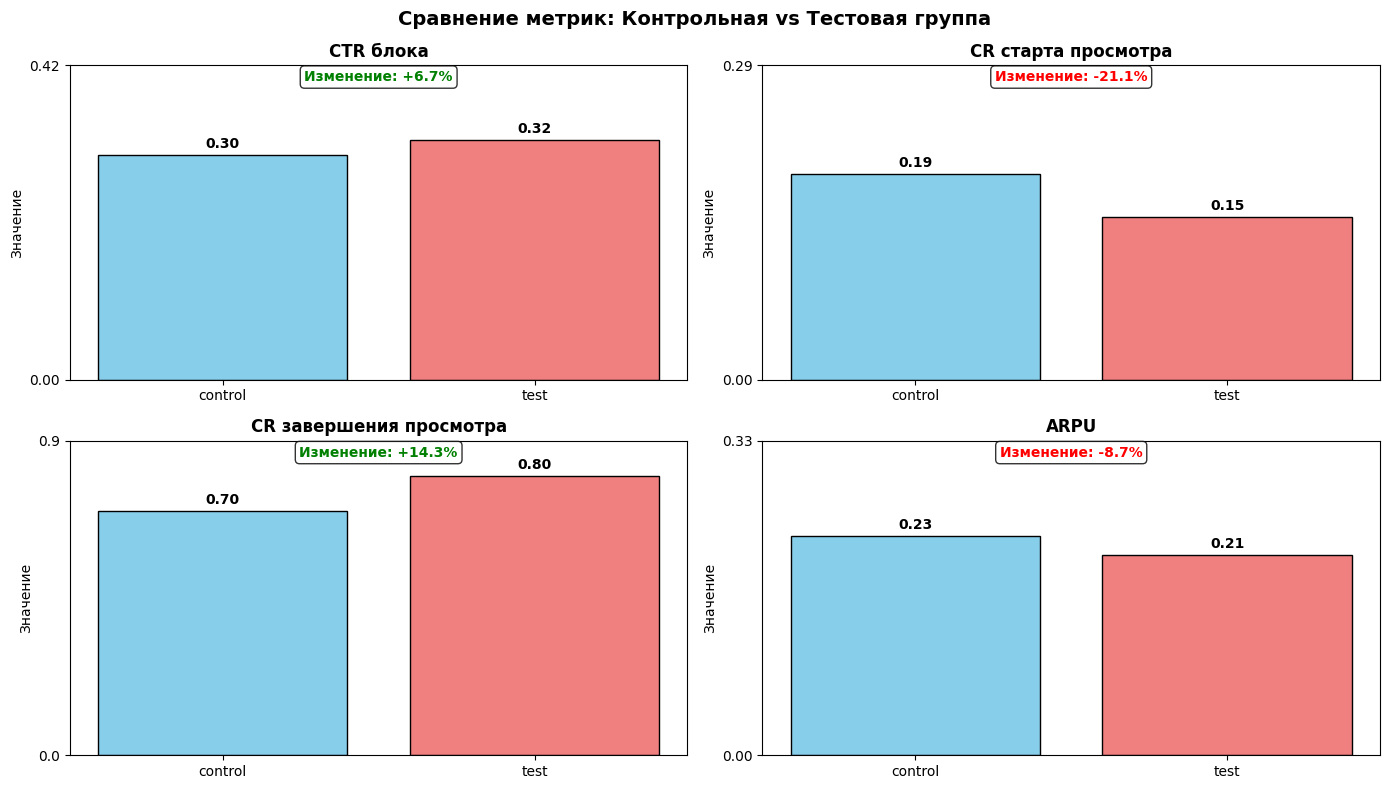

In [24]:
# Метрики для отображения
metrics = ['ctr_block', 'cr_start_watch', 'cr_finish_watch', 'arpu']
metric_names = ['CTR блока', 'CR старта просмотра', 'CR завершения просмотра', 'ARPU']

# Получаем данные
control_data = result_df[result_df['ab_group'] == 'control'].iloc[0]
test_data = result_df[result_df['ab_group'] == 'test'].iloc[0]

# Значения для графика
groups = ['control', 'test']
colors = ['skyblue', 'lightcoral']

# Настройка графика
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()



# Создаем столбцы для контрольной и тестовой групп
for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx]

    # Столбчатая диаграмма
    values = [control_data[metric], test_data[metric]]
    bars = ax.bar(groups, values, color=colors, edgecolor='black')

    # Настройки для каждой подграфики
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Значение')
    ax.set_yticks([0, max(values)+0.1])
    ax.grid(False)

    # Добавляем значения на столбцы
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontweight='bold')

    # Рассчитываем изменение
    change = ((test_data[metric] - control_data[metric]) / control_data[metric]) * 100
    change_color = 'green' if change > 0 else 'red'

    # Добавляем аннотацию с изменением
    ax.text(0.5, 0.95, f'Изменение: {change:+.1f}%',
            transform=ax.transAxes, ha='center',
            color=change_color, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.suptitle('Сравнение метрик: Контрольная vs Тестовая группа', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Нельзя однозначно выделить одну из групп, как лучшую. Тестовая группа превосходит контрольную в метриках CTR блока на (+6.7%) и CR завершения просмотра на (+14.3%). Но уступает контрольной группе в метриках CR старта просмотра (-21.1%) и ARPU (-8.7%).

**Сравниваем оплату за контент**

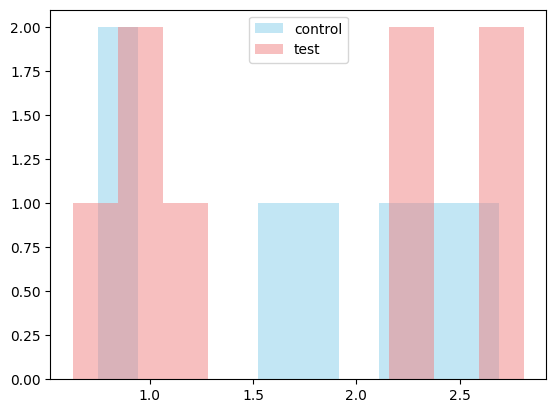

In [25]:
# Строим гистограммы оплат для каждой группы
plt.hist(df[df['ab_group']=='control']['value'], alpha=0.5, label='control', color='skyblue')
plt.hist(df[df['ab_group']=='test']['value'], alpha=0.5, label='test', color='lightcoral')
plt.legend()
plt.show()

Распределение показывает, что тестовая группа больше тратит на оплату контента. Но стоит учесть, что в тестовой группе больше пользователей, а по метрике ARPU (оплата на пользователя) она уступает контрольной.

**Сравниваем пользовательские воронки**

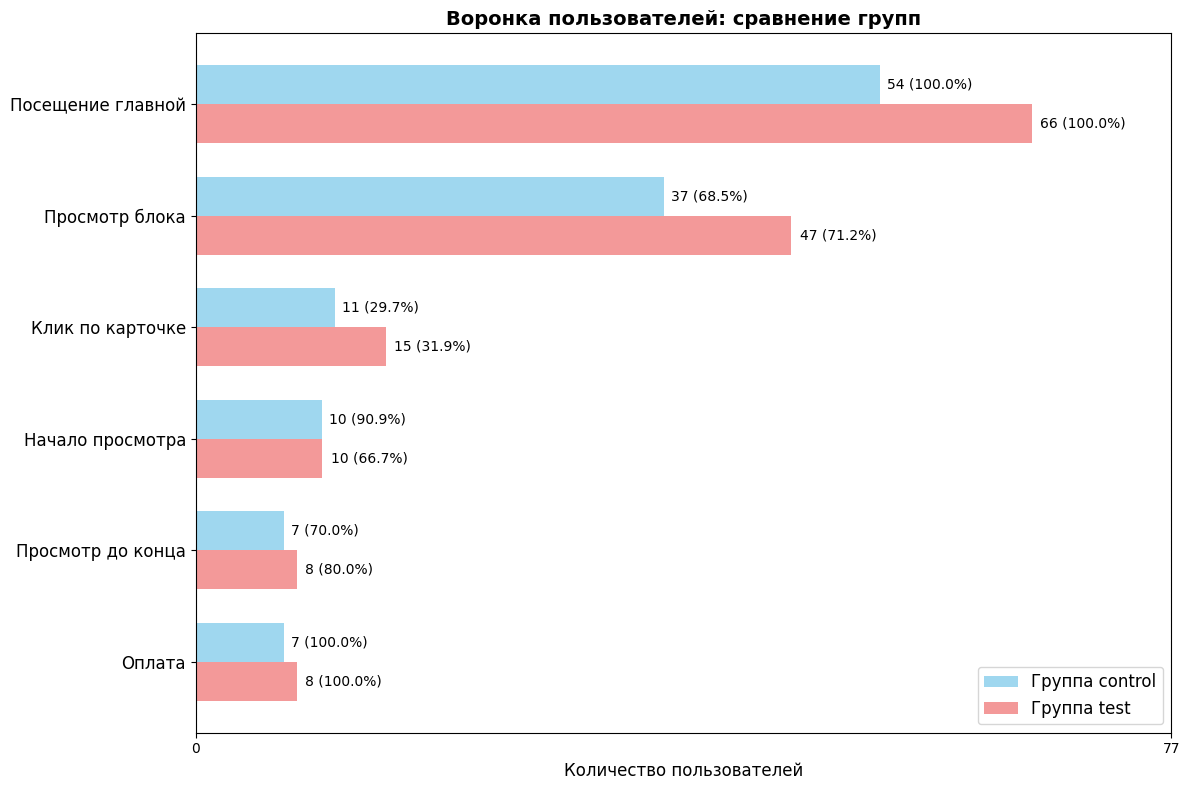

In [26]:
# Создаем данные для воронки по группам
funnel_data = []

for group in result_df['ab_group'].unique():
    group_data = result_df[result_df['ab_group'] == group].iloc[0]

    funnel_steps = [
        ('Посещение главной', group_data['view_home_count']),
        ('Просмотр блока', group_data['view_block_count']),
        ('Клик по карточке', group_data['click_block_count']),
        ('Начало просмотра', group_data['start_watch_count']),
        ('Просмотр до конца', group_data['finish_watch_count']),
        ('Оплата', group_data['revenue_count'])
    ]

    # Вычисляем конверсию между шагами
    conversions = []
    for i in range(len(funnel_steps)):
        if i == 0:
            conversions.append(100)  # Первый шаг = 100%
        else:
            conv = (funnel_steps[i][1] / funnel_steps[i-1][1]) * 100
            conversions.append(round(conv, 2))

    funnel_data.append({
        'group': group,
        'steps': [step[0] for step in funnel_steps],
        'values': [step[1] for step in funnel_steps],
        'conversions': conversions
    })

# Создаем один график с двумя группами рядом
fig, ax = plt.subplots(figsize=(12, 8))

# Определяем цвета для групп
colors = ['skyblue', 'lightcoral']

# Определяем позиции для столбцов
steps = funnel_data[0]['steps']
y_pos = np.arange(len(steps))
bar_width = 0.35

# Рисуем столбцы для каждой группы
for idx, data in enumerate(funnel_data):
    offset = -bar_width/2 if idx == 0 else bar_width/2

    bars = ax.barh(y_pos + offset, data['values'],
                   height=bar_width,
                   color=colors[idx],
                   alpha=0.8,
                   label=f'Группа {data["group"]}')

    # Добавляем подписи значений
    for i, (value, conv) in enumerate(zip(data['values'], data['conversions'])):
        text_x = value + max(data['values']) * 0.01
        ax.text(text_x, i + offset,
                f'{int(value):,} ({conv:.1f}%)',
                va='center',
                fontsize=10,
                fontweight='bold' if conv < 1 else 'normal')

# Настраиваем оси
ax.set_yticks(y_pos)
ax.set_xticks([0, 77])
ax.set_yticklabels(steps, fontsize=12)
ax.set_xlabel('Количество пользователей', fontsize=12)
ax.set_title('Воронка пользователей: сравнение групп', fontsize=14, fontweight='bold')

# Добавляем легенду
ax.legend(loc='lower right', fontsize=12)

# Добавляем сетку для лучшей читаемости
ax.grid(True, axis='x', alpha=0.3, linestyle='--')

# Инвертируем ось Y, чтобы оплата была внизу
ax.invert_yaxis()

plt.tight_layout()
plt.show()

На пользовательской воронке тестовая группа однозначно смотрится лучше. На это может влиять большее количество пользователей в тесте. В начало просмотра контента приходит одинаковое количество пользователей, не смотря на изначальную их разницу в группах. В контрольной группе в начало просмотра после клика по карточке переходят охотнее. Стоит обратить внимание, что в тестовой группе 28.8% пользователей посетившие домашнюю страницу не просматривают блок с премьерами, хотя он находится в самом верху. Возможно стоит доработать его, чтобы он больше привлекал внимание. В относительном сравнении с контрольной группой разница не велика, там не просматривают блок 31.5% пользователей.

### 3.3 Промежуточные выводы

* Однозначного победителя нет. Тестовая группа показывает лучшие результаты в пользовательской воронке, но уступает в конверсии в начало просмотра и средних тратах на пользователя (ARPU).
* Относительная разница просмотра блока с премьерами в группах не особо велика, не смотря на то, что в тестовой группе этот блок находится в самом верху.
* Эффект увеличения общей выручки может объясняться исключительно большим размером группы, а не улучшением пользовательского опыта.
* Более подробные выводы можно будет сделать после статистического теста.

## 4. Проведение бутстрэп тестов

### 4.1 Бутстрэп тест для CTR блока

**Подготовка данных**

In [27]:
def prepare_user_ctr_data(df):
    """Создает DataFrame с CTR для каждого пользователя"""
    user_data = []

    for client_id in df['client_id'].unique():
        user_df = df[df['client_id'] == client_id]
        views = (user_df['event_type'] == 'view_block').sum()
        clicks = (user_df['event_type'] == 'click_block').sum()

        if views > 0:  # Только пользователи, у которых были просмотры
            ctr = clicks / views
            group = user_df['ab_group'].iloc[0]
            user_data.append({
                'client_id': client_id,
                'ctr': ctr,
                'ab_group': group
            })

    return pd.DataFrame(user_data)

# Создаем данные по пользователям
user_ctr_df = prepare_user_ctr_data(df)

# Разделяем на группы
test_ctr_values = user_ctr_df[user_ctr_df['ab_group'] == 'test']['ctr'].values
control_ctr_values = user_ctr_df[user_ctr_df['ab_group'] == 'control']['ctr'].values

print(f"Тестовая группа: {len(test_ctr_values)} пользователей с просмотренным блоком")
print(f"Контрольная группа: {len(control_ctr_values)} пользователей с просмотренным блоком")

Тестовая группа: 47 пользователей с просмотренным блоком
Контрольная группа: 37 пользователей с просмотренным блоком


Данных мало, но тест можно провести. Надежность теста будет умеренная.

In [28]:
# Проверяем соотношение групп
ratio = len(test_ctr_values) / len(control_ctr_values)
if ratio < 0.5 or ratio > 2.0:
    print(f"Внимание! Размеры групп несбалансированы, соотношение: {ratio:.2f}")
else:
    print(f"Соотношение между группами в пределах нормы: {ratio:.2f}")

Соотношение между группами в пределах нормы: 1.27


In [29]:
# Проверяем описательную статистику
print(f"Тестовая группа --> среднее значение: {np.mean(test_ctr_values):.2f}, стандартное отклонение: {np.std(test_ctr_values):.2f}")
print(f"Контрольная группа --> среднее значение: {np.mean(control_ctr_values):.2f}, стандартное отклонение: {np.std(control_ctr_values):.2f}")

Тестовая группа --> среднее значение: 0.32, стандартное отклонение: 0.47
Контрольная группа --> среднее значение: 0.30, стандартное отклонение: 0.46


Разница средних в пользу теста, стандартные отклонения почти равны. Разница в 2.2% может быть как значимой, так и случайной. Нельзя сказать о статистической значимости без p-value и доверительного интервала. Бутстрэпу не нужны проверки на нормальность распределения или равенство дисперсий, поэтому приступим к тесту.

**Проводим тест**

Нулевая гипотеза (H₀):
>Различие CTR блока между тестовой и контрольной группами статистически незначимо и не превышает 2.5%.

Альтернативная гипотеза (H₁):
>CTR блока в тестовой группе превышает CTR блока в контрольной группе более чем на 2.5%.

In [37]:
def bootstrap_p_value(group1, group2, n_iterations=5000):
    """Бутстрэп для сравнения двух групп"""
    # Наблюдаемая разница средних
    observed_diff = np.mean(group1) - np.mean(group2)
    # Объединенная выборка
    combined = np.concatenate([group1, group2])

    bootstrap_diffs = []
    for _ in range(n_iterations):
        # Сэмплируем с возвращением
        sample1 = np.random.choice(combined, size=len(group1), replace=True)
        sample2 = np.random.choice(combined, size=len(group2), replace=True)
        # Разница средних в бутстрэп выборке
        bootstrap_diffs.append(np.mean(sample1) - np.mean(sample2))

    # Односторонний тест
    p_value = np.mean(bootstrap_diffs >= observed_diff)
    return p_value, observed_diff, bootstrap_diffs

# Запуск теста
simple_p, simple_diff, bootstrap_diffs = bootstrap_p_value(test_ctr_values, control_ctr_values)

print(f"Разница средних значений в группах: {simple_diff:.3f}")
print(f"P-value: {simple_p:.3f}")
print(f"95% Доверительный интервал: [{np.percentile(bootstrap_diffs, 2.5):.3f}, {np.percentile(bootstrap_diffs, 97.5):.3f}]")

# Интерпретация
if simple_p < 0.05:
    if simple_diff > 0:
        print("\n✅ Статистически значимо, у тестовой группы более высокий CTR.")
    else:
        print("\n⚠️ Статистически значимо, но у тестовой группы CTR ниже.")
else:
    print("\n❌ Статистически незначимо, отклоняем гипотезу.")

Разница средних значений в группах: 0.022
P-value: 0.419
95% Доверительный интервал: [-0.193, 0.198]

❌ Статистически незначимо, отклоняем гипотезу.


**Визуализация теста**

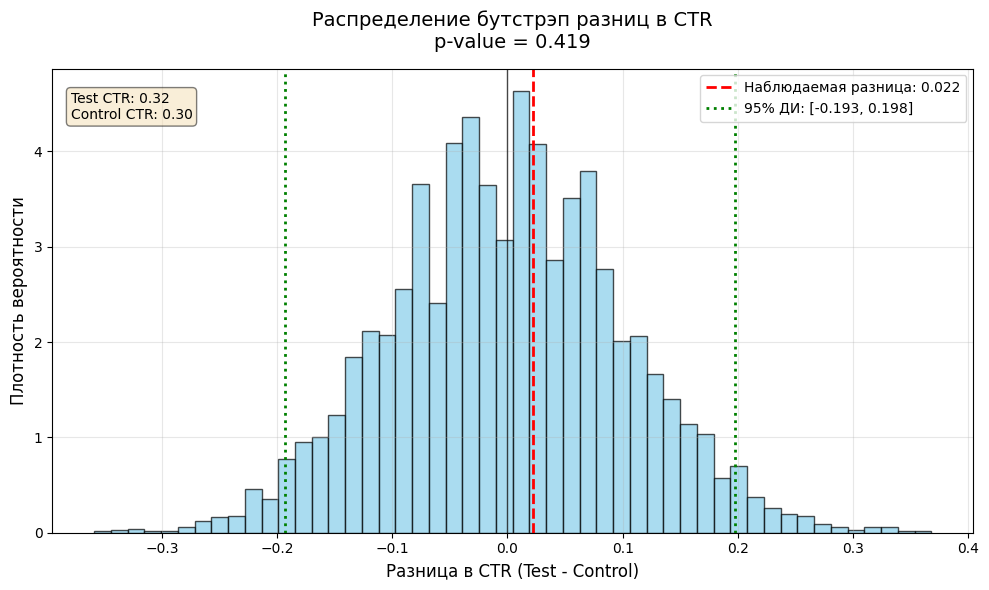

In [38]:
# Визуализация распределения бутстрэп разниц
plt.figure(figsize=(10, 6))

# Гистограмма бутстрэп разниц
plt.hist(bootstrap_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)

# Добавляем наблюдаемую разницу
plt.axvline(simple_diff, color='red', linestyle='--', linewidth=2,
            label=f'Наблюдаемая разница: {simple_diff:.3f}')

# Добавляем доверительный интервал
plt.axvline(np.percentile(bootstrap_diffs, 2.5), color='green', linestyle=':', linewidth=2,
            label=f'95% ДИ: [{np.percentile(bootstrap_diffs, 2.5):.3f}, {np.percentile(bootstrap_diffs, 97.5):.3f}]')
plt.axvline(np.percentile(bootstrap_diffs, 97.5), color='green', linestyle=':', linewidth=2)

# Линия нулевой разницы
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)

# Настройки графика
plt.xlabel('Разница в CTR (Test - Control)', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.title(f'Распределение бутстрэп разниц в CTR\np-value = {simple_p:.3f}', fontsize=14, pad=15)

# Добавляем легенду
plt.legend(fontsize=10)

# Добавляем сетку
plt.grid(True, alpha=0.3)

# Добавляем информацию о группах в тексте
plt.text(0.02, 0.95, f'Test CTR: {np.mean(test_ctr_values):.2f}\nControl CTR: {np.mean(control_ctr_values):.2f}',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

Разница средних: +0.022 (2.2 процентных пункта в пользу теста), но эффект слишком мал и нестабилен для выводов. Доверительный интервал [-0.193, 0.198]
включает ноль, эффект может быть как положительным, так и отрицательным. Неопределенность высока: реальный эффект может быть от -19.3% до +19.8%.

###  4.2 Бутстрэп тест для CR в просмотр

**Подготовка данных**

In [39]:
def prepare_user_watch_data(df):
    """Создает DataFrame с метрикой CR_в_просмотр для каждого пользователя"""
    user_data = []

    for client_id in df['client_id'].unique():
        user_df = df[df['client_id'] == client_id]

        # Считаем просмотры домашней страницы и начала просмотров
        home_views = (user_df['event_type'] == 'view_home').sum()
        start_watches = (user_df['event_type'] == 'start_watch').sum()

        if home_views > 0:  # Только пользователи, которые были на домашней странице
            conversion_rate = start_watches / home_views
            group = user_df['ab_group'].iloc[0]
            user_data.append({
                'client_id': client_id,
                'cr_to_watch': conversion_rate,  # CR в просмотр
                'ab_group': group
            })

    return pd.DataFrame(user_data)

# Создаем данные по пользователям
user_watch_df = prepare_user_watch_data(df)

# Разделяем на группы
test_cr_values = user_watch_df[user_watch_df['ab_group'] == 'test']['cr_to_watch'].values
control_cr_values = user_watch_df[user_watch_df['ab_group'] == 'control']['cr_to_watch'].values

print(f"Тестовая группа: {len(test_cr_values)} пользователей с просмотренной домашней страницей")
print(f"Контрольная группа: {len(control_cr_values)} пользователей с просмотренной домашней страницей")

Тестовая группа: 66 пользователей с просмотренной домашней страницей
Контрольная группа: 54 пользователей с просмотренной домашней страницей


Данных мало, но тест можно провести. Надежность теста будет умеренная.

In [33]:
# Проверяем соотношение групп
ratio = len(test_cr_values) / len(control_cr_values)
if ratio < 0.5 or ratio > 2.0:
    print(f"Внимание! Размеры групп несбалансированы, соотношение: {ratio:.2f}")
else:
    print(f"Соотношение между группами в пределах нормы: {ratio:.2f}")

Соотношение между группами в пределах нормы: 1.22


In [34]:
# Проверяем описательную статистику
print(f"Тестовая группа --> среднее значение: {np.mean(test_cr_values):.2f}, стандартное отклонение: {np.std(test_cr_values):.2f}")
print(f"Контрольная группа --> среднее значение: {np.mean(control_cr_values):.2f}, стандартное отклонение: {np.std(control_cr_values):.2f}")

Тестовая группа --> среднее значение: 0.15, стандартное отклонение: 0.36
Контрольная группа --> среднее значение: 0.19, стандартное отклонение: 0.39


Контрольная группа показывает лучший результат, но разница может быть незначимой из-за большого стандартного отклонения. Требуется больше данных для надежного вывода. Приступим к тесту.

**Проводим тест**

Нулевая гипотеза (H₀):
>Различие CR в просмотр между тестовой и контрольной группами статистически незначимо и не превышает 2.5%.

Альтернативная гипотеза (H₁):
>CR в просмотр в тестовой группе превышает CR в просмотр в контрольной группе более чем на 2.5%.

In [40]:
def bootstrap_p_value(group1, group2, n_iterations=5000):
    """Бутстрэп для сравнения двух групп"""
    # Наблюдаемая разница средних
    observed_diff = np.mean(group1) - np.mean(group2)
    # Объединенная выборка
    combined = np.concatenate([group1, group2])

    bootstrap_diffs = []
    for _ in range(n_iterations):
        # Сэмплируем с возвращением
        sample1 = np.random.choice(combined, size=len(group1), replace=True)
        sample2 = np.random.choice(combined, size=len(group2), replace=True)
        # Разница средних в бутстрэп выборке
        bootstrap_diffs.append(np.mean(sample1) - np.mean(sample2))

    # Односторонний тест
    p_value = np.mean(bootstrap_diffs >= observed_diff)
    return p_value, observed_diff, bootstrap_diffs

# Запуск теста
simple_p, simple_diff, bootstrap_diffs = bootstrap_p_value(test_cr_values, control_cr_values)

print(f"Разница средних значений в группах: {simple_diff:.3f}")
print(f"P-value: {simple_p:.3f}")
print(f"95% Доверительный интервал: [{np.percentile(bootstrap_diffs, 2.5):.3f}, {np.percentile(bootstrap_diffs, 97.5):.3f}]")

# Интерпретация
if simple_p < 0.05:
    if simple_diff > 0:
        print("\n✅ Статистически значимо, у тестовой группы более высокий CR.")
    else:
        print("\n⚠️ Статистически значимо, но у тестовой группы CR ниже.")
else:
    print("\n❌ Статистически незначимо, отклоняем гипотезу.")

Разница средних значений в группах: -0.034
P-value: 0.702
95% Доверительный интервал: [-0.135, 0.131]

❌ Статистически незначимо, отклоняем гипотезу.


**Визуализация теста**

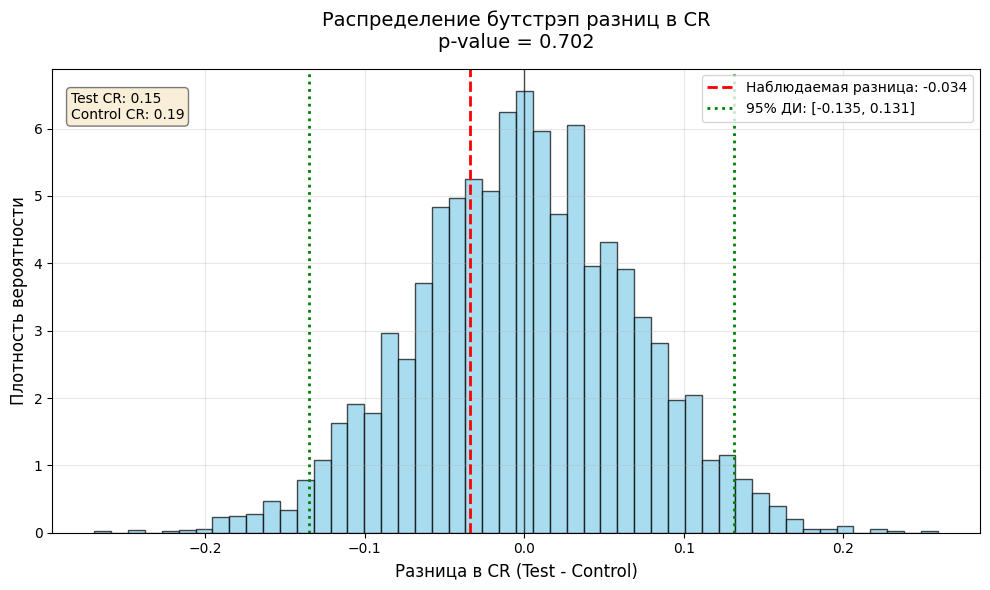

In [41]:
# Визуализация распределения бутстрэп разниц
plt.figure(figsize=(10, 6))

# Гистограмма бутстрэп разниц
plt.hist(bootstrap_diffs, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)

# Добавляем наблюдаемую разницу
plt.axvline(simple_diff, color='red', linestyle='--', linewidth=2,
            label=f'Наблюдаемая разница: {simple_diff:.3f}')

# Добавляем доверительный интервал
plt.axvline(np.percentile(bootstrap_diffs, 2.5), color='green', linestyle=':', linewidth=2,
            label=f'95% ДИ: [{np.percentile(bootstrap_diffs, 2.5):.3f}, {np.percentile(bootstrap_diffs, 97.5):.3f}]')
plt.axvline(np.percentile(bootstrap_diffs, 97.5), color='green', linestyle=':', linewidth=2)

# Линия нулевой разницы
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.7)

# Настройки графика
plt.xlabel('Разница в CR (Test - Control)', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.title(f'Распределение бутстрэп разниц в CR\np-value = {simple_p:.3f}', fontsize=14, pad=15)

# Добавляем легенду
plt.legend(fontsize=10)

# Добавляем сетку
plt.grid(True, alpha=0.3)

# Добавляем информацию о группах в тексте
plt.text(0.02, 0.95, f'Test CR: {np.mean(test_cr_values):.2f}\nControl CR: {np.mean(control_cr_values):.2f}',
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

Разница средних: -0.034 (отрицательное значение), тестовая группа показала ниже конверсию на 3.4 процентных пункта. Но эта разница не статистически значима, вероятность получить такую разницу случайно: 70.4%. Доверительный интервал [-0.135, 0.131] включает 0, разница может быть нулевой. Максимальный возможный эффект от -13.5% до +13.1%. Эффект слишком неопределенный для выводов.

### 4.3 Промежуточные выводы

* Проведенный A/B-тест для CTR блока не выявил статистически значимой разницы между тестовой и контрольной группами. Наблюдаемое различие в 2.2 процентных пункта может быть объяснено случайной вариацией данных, об этом говорит слишком широкий доверительный интервал, включающий ноль.
* Проведенный A/B-тест для CR в начало просмотра не выявил статистически значимой разницы между тестовой и контрольной группами. Конверсия в тестовой группе на 3.4 процентных пункта ниже, чем в контрольной.
* Гипотезу стоит отклонить, воздействие этой фичи может ухудшить метрики приложения.

## **Общий вывод**

* Собрано только 120 пользователей, расчетный размер выборки значительно превышает нашу экспериментальную группу. На нашей выборке мы сможем обнаружить MDE, который будет превышать 24-25%. Для обнаружения эффекта в 2.5% потребуется выборка из более чем 8000 пользователей.
* Продолжительность теста была 6 дней вместо 7 дней.
* Исходя из того, что выборка маленькая, был проведен бутстрэп тест для двух метрик: CTR блока и CR в начало просмотра. Оба теста не показали статистически значимой разницы между тестовой и контрольной группой.
* Бутстрэп тесты показали широкие доверительные интервалы, включающие ноль, поэтому сложно оценить влияние изменения на наши метрики. Также широкие интервалы показывают, что у нас мало данных для выявления стабильного и значимого результата.
* Результаты статистически ненадёжны и не могут быть основанием для принятия решения. Требуется большее количество пользователей в тесте, чтобы сделать качественные заключения.
* Сравнение групп по метрикам показывает, что тестовая группа уступает в конверсии в начало просмотра, 19% - контроль и 15% - тест; в средних тратах на пользователя (ARPU), 0.23 у.е. - контроль, 0.21 у.е. - тест.
* После посещения домашней страницы относительная разница просмотра блока с премьерами в группах не особо велика, 28.8% в тестовой группе и 31.5% в контрольной. Хотя в тестовой группе этот блок находится в самом верху.

## **Рекомендации**

1) Пока не стоит раскатывать фичу, есть вероятность, что изменения негативно повлияют на метрики. Рекомендуется сохранить текущую версию интерфейса.
2) Рекомендуется перезапустить тест на более ёмком канале, для качественных выводов нужно увеличить выборку и продлить эксперимент.
3) Стоит доработать блок с премьерами в тестовой группе. Из эксперимента видно, что относительная разница просмотра блока с премьерами между группами не особо велика, хотя в тестовой группе этот блок находится в самом верху.
4) Использовать этот эксперимент как пилотное исследование для формирования новых гипотез и проанализировать отзывы клиентов из тестовой группы.